# **Task 1 (70 points):**

**Part 1 (20 points):** This step involves downloading, preparing, and visualizing your
dataset. Create a convolutional base using a common pattern: a stack of Conv and
MaxPooling layers. Depending on the problem and the dataset you must decide what
pattern you want to use (i.e., how many Conv layers and how many pooling layers).
Please describe why you chose a particular pattern. Add the final dense layer(s).
Compile and train the model. Report the final evaluation and describe the metrics.

In [117]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt, image as img
from pathlib import Path
from os import makedirs
import shutil
from PIL import Image

In [118]:
# Load dataset
df = pd.read_csv("Projects_ML_AI/Project5/train.csv")
df

,filepath,team_name,team
0,../input/english-premier-league-logo-detection...,manchester-united,12
1,../input/english-premier-league-logo-detection...,manchester-united,12
2,../input/english-premier-league-logo-detection...,manchester-united,12
3,../input/english-premier-league-logo-detection...,manchester-united,12
4,../input/english-premier-league-logo-detection...,manchester-united,12
...,...,...,...
19995,../input/english-premier-league-logo-detection...,brentford,2
19996,../input/english-premier-league-logo-detection...,brentford,2
19997,../input/english-premier-league-logo-detection...,brentford,2
19998,../input/english-premier-league-logo-detection...,brentford,2


In [119]:
# Replace part of file paths in the 'filepath' column
prefix = '../input/english-premier-league-logo-detection-20k-images'
path = 'Projects_ML_AI/Project5'
df['filepath'] = df['filepath'].str.replace(prefix, path)
df

,filepath,team_name,team
0,Projects_ML_AI/Project5/epl-logos-big/epl-logo...,manchester-united,12
1,Projects_ML_AI/Project5/epl-logos-big/epl-logo...,manchester-united,12
2,Projects_ML_AI/Project5/epl-logos-big/epl-logo...,manchester-united,12
3,Projects_ML_AI/Project5/epl-logos-big/epl-logo...,manchester-united,12
4,Projects_ML_AI/Project5/epl-logos-big/epl-logo...,manchester-united,12
...,...,...,...
19995,Projects_ML_AI/Project5/epl-logos-big/epl-logo...,brentford,2
19996,Projects_ML_AI/Project5/epl-logos-big/epl-logo...,brentford,2
19997,Projects_ML_AI/Project5/epl-logos-big/epl-logo...,brentford,2
19998,Projects_ML_AI/Project5/epl-logos-big/epl-logo...,brentford,2


In [120]:
widths = []
heights = []
for i in df['filepath']:
    im = Image.open(i)
    w,h = im.size
    widths.append(w)
    heights.append(h)
print(f"sizes avg = ({sum(widths)//len(widths)},{sum(heights)//len(heights)})")

sizes avg = (135,135)


In [121]:
df = df.drop('team',axis=1)

In [122]:
len(df.groupby('team_name').count())

20

In [123]:
df.value_counts('team_name')

team_name
wolves               1000
west-ham             1000
aston-villa          1000
brentford            1000
brighton             1000
burnley              1000
chelsea              1000
crystal-palace       1000
everton              1000
leeds                1000
leicester-city       1000
liverpool            1000
manchester-city      1000
manchester-united    1000
newcastle            1000
norwich              1000
southampton          1000
tottenham            1000
watford              1000
arsenal              1000
dtype: int64

In [182]:
# Preprocess dataset
img_size = (135,135)
batch_size = 32
SEED = 42

In [172]:
# Define data path
dataPath = Path("Projects_ML_AI/Project5/epl-logos-big/epl-logos-big/")

In [173]:
# Create TensorFlow datasets
trainDS = tf.keras.utils.image_dataset_from_directory(
    dataPath,
    validation_split=0.3,
    label_mode='categorical',
    subset="training",
    seed=SEED,  # You can set a seed for reproducibility
    image_size=img_size,  # Set the desired image size
    batch_size=batch_size
)

Found 20000 files belonging to 20 classes.
Using 14000 files for training.


In [127]:
valDS = tf.keras.utils.image_dataset_from_directory(
    dataPath,
    validation_split=0.2,
    label_mode='categorical',
    subset="validation",
    seed=SEED,  # Same seed for consistency
    image_size=img_size,  # Same image size
    batch_size=batch_size
)

Found 20000 files belonging to 20 classes.
Using 4000 files for validation.


In [189]:
valDS

<SkipDataset shapes: ((None, 135, 135, 3), (None, 20)), types: (tf.float32, tf.float32)>

In [128]:
cardinality = tf.data.experimental.cardinality(valDS)
halfed = cardinality//2
testDS = valDS.take(halfed)
valDS = valDS.skip(halfed)

In [129]:
teams = trainDS.class_names
teams

['arsenal',
 'aston-villa',
 'brentford',
 'brighton',
 'burnley',
 'chelsea',
 'crystal-palace',
 'everton',
 'leeds',
 'leicester-city',
 'liverpool',
 'manchester-city',
 'manchester-united',
 'newcastle',
 'norwich',
 'southampton',
 'tottenham',
 'watford',
 'west-ham',
 'wolves']

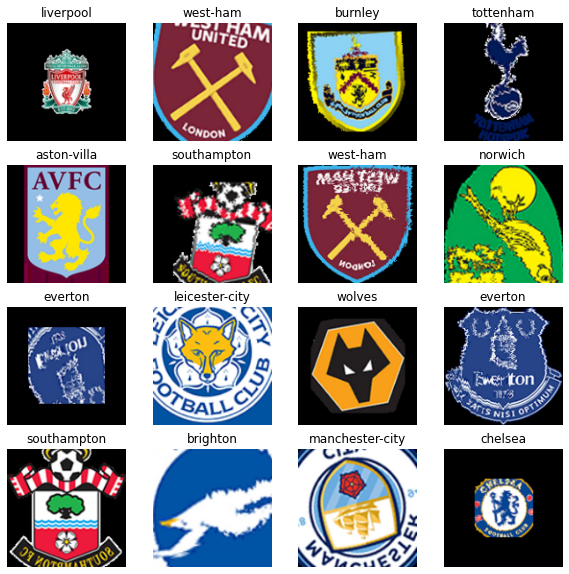

In [131]:
# Display some samples
plt.figure(figsize=(10, 10))
for images, labels in trainDS.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Assumes labels are one-hot encoded
        plt.title(teams[np.argmax(labels[i])])
        plt.axis("off")

plt.show()

In [132]:
# Model Implementation

model = tf.keras.Sequential([

    # Input Layer
    tf.keras.layers.Resizing(
        256, 256, input_shape=(img_size[0], img_size[1], 3)),

    # Convolutional Layers
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(teams))
])

In [133]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)       

In [134]:
history = model.fit(
    trainDS,
    validation_data=valDS,
    epochs=10
)

Epoch 1/10
438/438 [==============================] - 298s 677ms/step - loss: 2.6893 - accuracy: 0.6156 - val_loss: 0.1546 - val_accuracy: 0.9638
Epoch 2/10
438/438 [==============================] - 301s 683ms/step - loss: 0.2390 - accuracy: 0.9199 - val_loss: 0.1424 - val_accuracy: 0.9787
Epoch 3/10
438/438 [==============================] - 301s 683ms/step - loss: 0.1000 - accuracy: 0.9703 - val_loss: 0.0655 - val_accuracy: 0.9861
Epoch 4/10
438/438 [==============================] - 298s 677ms/step - loss: 0.0652 - accuracy: 0.9791 - val_loss: 0.0188 - val_accuracy: 0.9945
Epoch 5/10
438/438 [==============================] - 303s 689ms/step - loss: 0.0753 - accuracy: 0.9771 - val_loss: 0.0265 - val_accuracy: 0.9955
Epoch 6/10
438/438 [==============================] - 300s 682ms/step - loss: 0.0496 - accuracy: 0.9864 - val_loss: 0.0545 - val_accuracy: 0.9881
Epoch 7/10
438/438 [==============================] - 298s 678ms/step - loss: 0.0656 - accuracy: 0.9840 - val_loss: 0.2255 -

In [135]:
loss, accuracy = model.evaluate(testDS)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

62/62 [==============================] - 9s 136ms/step - loss: 0.0423 - accuracy: 0.9884
Test loss: 0.042320262640714645, Test accuracy: 0.9884072542190552


**Part 2 (25 points):** The following models are widely used for transfer learning because of
their performance and architectural innovations:

1. VGG (e.g., VGG16 or VGG19).
2. GoogLeNet (e.g., InceptionV3).
3. Residual Network (e.g., ResNet50).
4. MobileNet (e.g., MobileNetV2)

Choose any **one** of the above models to perform the classification task you did in Part 1.
Evaluate the results using the same metrics as in Part 1. Are there any differences? Why
or why not? Describe in detail.

In [183]:
img_size = img_size[0]

In [188]:
from tensorflow.keras.applications import MobileNetV2

# Pre-trained MobileNetV2 model with weights loaded from ImageNet
base_model = MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers (optional)
base_model.trainable = False  # Freeze base model layers for fine-tuning

OSError: Unable to open file (unable to lock file, errno = 5, error message = 'Input/output error')

In [186]:
from tensorflow.keras.applications import VGG16

# Pre-trained VGG16 model with weights loaded from ImageNet
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(img_size, img_size, 3))

# Freeze the base model layers (optional)
base_model.trainable = False  # Freeze base model layers for fine-tuning

OSError: Unable to open file (unable to lock file, errno = 5, error message = 'Input/output error')

In [163]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

In [180]:
# Load pre-trained ResNet50 model
img_size = img_size[0]
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_size, img_size, 3))

KeyboardInterrupt: 

In [ ]:
# Modify top layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(
    x)  # Add new dense layer(s) as needed
predictions = layers.Dense(num_classes, activation='softmax')(
    x)  # Output layer for classification

# Create model
model = models.Model(inputs=base_model.input, outputs=predictions)

# Optionally, freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(trainDS, validation_data=valDS, epochs=num_epochs)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(testDS)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

InceptionV3

In [162]:
size = img_size[0]
googleInception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    input_shape=(size, size, 3),
    weights='imagenet'
)

OSError: Unable to open file (unable to lock file, errno = 5, error message = 'Input/output error')

In [ ]:
input = tf.keras.Input((size, size, 3))
x = tf.keras.applications.inception_v3.preprocess_input(input)
x = googleInception(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(teams))(x)
model = tf.keras.Model(input, output)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

In [ ]:
history = model.fit(
    trainDS,
    validation_data=valDS,
    epochs=6
)

**Part 3 (25 points):** Use data augmentation to increase the diversity of your dataset by
applying random transformations such as image rotation (you can use any other
technique as well). Repeat the process from part 1 with this augmented data. Did you
observe any difference in results?

In [138]:
model = tf.keras.Sequential([

    # Input Layer
    tf.keras.layers.Resizing(256, 256, input_shape=(size, size, 3)),

    # Random Flip and Rotation
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),

    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255),

    # Convolutional Layers
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(types))

])

In [139]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 128, 128, 16)     

In [141]:
history = model.fit(
    trainDS,
    validation_data=valDS,
    epochs=10
)

Epoch 1/10
438/438 [==============================] - 344s 786ms/step - loss: 0.5559 - accuracy: 0.8199 - val_loss: 0.1125 - val_accuracy: 0.9573
Epoch 2/10
438/438 [==============================] - 339s 770ms/step - loss: 0.0852 - accuracy: 0.9745 - val_loss: 0.0219 - val_accuracy: 0.9955
Epoch 3/10
438/438 [==============================] - 333s 754ms/step - loss: 0.0626 - accuracy: 0.9831 - val_loss: 0.0075 - val_accuracy: 0.9985
Epoch 4/10
438/438 [==============================] - 327s 743ms/step - loss: 0.0369 - accuracy: 0.9886 - val_loss: 0.0103 - val_accuracy: 0.9970
Epoch 5/10
438/438 [==============================] - 320s 729ms/step - loss: 0.0481 - accuracy: 0.9872 - val_loss: 0.0388 - val_accuracy: 0.9955
Epoch 6/10
438/438 [==============================] - 145s 328ms/step - loss: 0.0199 - accuracy: 0.9949 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 7/10
438/438 [==============================] - 116s 265ms/step - loss: 0.0264 - accuracy: 0.9934 - val_loss: 0.0050 -

# **Task 2 (30 points):**

**Part 1 (15 points): Variational Autoencoder (VAE):** Here is a complete implementation
of a VAE in TensorFlow: https://www.tensorflow.org/tutorials/generative/cvae

PyTorch implementation is fine too.

Following these steps try generating images using the same encoder-decoder architecture using
a different Image dataset (other than MNIST).

In [143]:
def preprocess_images(images):
  images = images/255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = np.concatenate([x for x, y in trainDS], axis=0)
test_images = np.concatenate([x for x, y in valDS], axis=0)

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [144]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(size, size, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=32**3, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(32, 32, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [145]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [147]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 200
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [148]:
train_size = 60000
batch_size = 32
test_size = 10000

In [149]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [150]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [151]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [154]:
import time
from IPython import display

generate_and_save_images(model, 0, test_sample)

ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (16, 135, 135, 3)

In [ ]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

**Part 2 (15 points): Generative Adversarial Networks (GANs):** Repeat part 1 (use same
dataset) and implement a GAN model to generate high quality synthetic images. You may
follow steps outlined here: https://www.tensorflow.org/tutorials/generative/dcgan